# JAX 1D-FDM + Generalized Sigmoid c(Tw) Function

## 목적
온도 의존 열전달계수 c(Tw)를 **일반화된 Sigmoid 함수**로 모델링하여 모든 실험 케이스(140W, 280W, 420W) 동시 피팅

## c(Tw) 함수 설계
```
c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
```

### 특성:
- **저온 (Tw → -∞)**: c → c_min (하한값으로 수렴, 0 이하로 안 내려감)
- **고온 (Tw → +∞)**: c → c_max (상한값으로 수렴)
- **T_mid**: 전이 중심 온도 (기울기가 최대인 지점)
- **k_sig**: 전이 기울기 (클수록 steep, 작을수록 완만)

### 목표 c 값 (test_jax_5-7 참고):
- 140W: c ≈ 25.63 (Tw ~ 400-550°C) - 전이 구간
- 280W: c ≈ 43.107 (Tw ~ 620-830°C) - 수렴 시작
- 420W: c ≈ 49.556 (Tw ~ 820-1050°C) - 상한 근처

### 관찰된 패턴:
- 140W → 280W: 약 17.5 증가 (급격한 전이)
- 280W → 420W: 약 6.5 증가 (상한으로 수렴)

## 파라미터 구조:
- **학습 파라미터**: c_min, c_max, k_sig, T_mid (4개)
- **고정 파라미터**: m=250, k=78, z1=0.1, z2=0.33

## hout 함수:
```
hout(z, Tw) = c(Tw) + m/k*ln(1+exp(k*(z1-z))) + m/k*ln(1+exp(k*(z-z2)))
```


In [8]:
# 0) 라이브러리 로드
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import lax
from jax import custom_vjp
import optax

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")


JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]


In [9]:
# 1) 데이터 로드 및 설정
tc_pos = jnp.array(json.load(open('tc_pos.json')))
T_140 = jnp.array(json.load(open('Temp_profile_140W.json')))
T_280 = jnp.array(json.load(open('Temp_profile_280W.json')))
T_420 = jnp.array(json.load(open('Temp_profile_420W.json')))

powers = jnp.array([140.0, 280.0, 420.0])
T_meas_cases = jnp.array([T_140, T_280, T_420])
num_cases, n_TC = T_meas_cases.shape

print(f"Cases: {num_cases}, TC count: {n_TC}")

# 2) Geometry
L = 430e-3; ID = 5.03e-3; OD = 6.33e-3
Ai = jnp.pi * ID**2 / 4; Ao = jnp.pi * OD**2 / 4; Aw = Ao - Ai
pri = jnp.pi * ID; pro = jnp.pi * OD
dz = 0.001; n_nodes = int(L/dz) + 1; z = jnp.linspace(0, L, n_nodes)
Awg = pri * dz; Aout = pro * dz
tc_idx = jnp.array([jnp.argmin(jnp.abs(z - zp)) for zp in tc_pos])

print(f"Nodes: {n_nodes}, Grid: {dz*1000:.2f} mm")

# 3) Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he); df_kt = pd.read_csv(path_kt)
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]; df_kt_cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]
Mw_he = 4.0026

## Jax-friendly 1D interpolation
def interp1d(xq, x, y):
    xq = jnp.asarray(xq)
    x  = jnp.asarray(x)
    y  = jnp.asarray(y)
    return jnp.interp(xq, x, y)

def rho_he(T): return interp1d(T, df_he['T [C]'], df_he['rho [kg/m3]'])
def cp_he(T): return interp1d(T, df_he['T [C]'], df_he['Cp [J/mol*K]'])
def k_he(T): return interp1d(T, df_he['T [C]'], df_he['Tc [W/m*K]'])
def rho_kt(T): return interp1d(T, df_kt['T [C]'], df_kt['rho [kg/m3]'])
def cp_kt(T): return interp1d(T, df_kt_cp['T [C]'], df_kt_cp['Cp [kJ/kg*K]'])*1000
def k_kt(T): return interp1d(T, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])
def h_wg(Tg): return 4.36 * k_he(Tg) / ID

# 4) Feed conditions
P = 101325.0; Tamb = 25.0; Fv_std = 50.0
Fw = Fv_std * 1e-6 / 60 * rho_he(0)
F = Fw / Mw_he * 1000.0

print("Setup complete")


Cases: 3, TC count: 16
Nodes: 431, Grid: 1.00 mm
Setup complete


In [54]:
# 5) 일반화된 Sigmoid 함수 기반 c(Tw) 및 hout(z, Tw) 정의

# 고정 상수
Z1_FIXED = 0.1
Z2_FIXED = 0.33
M_FIXED = 350.0   # 끝단 열손실 강도 (고정)
K_FIXED = 78.0    # 전환 기울기 (고정)

def compute_c_of_Tw(c_params, Tw_local):
    """
    일반화된 Sigmoid 함수 기반 온도 의존 c(Tw) 계산
    
    c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
    
    c_params: [c_min, c_max, k_sig, T_mid]
    - c_min: 저온 하한값 (Tw → -∞일 때 수렴값)
    - c_max: 고온 상한값 (Tw → +∞일 때 수렴값)
    - k_sig: 전이 기울기 (클수록 steep, 작을수록 완만)
    - T_mid: 전이 중심 온도 (기울기가 최대인 지점)
    
    특성:
    - 저온: c → c_min (하한값으로 수렴, 0 이하로 안 내려감)
    - 고온: c → c_max (상한값으로 수렴)
    - Tw = T_mid: c = (c_min + c_max) / 2
    - monotonic 증가 보장 (sigmoid 특성)
    - 양쪽 모두 부드러운 수렴 (급격한 변화 없음)
    """
    c_min, c_max, k_sig, T_mid = c_params[0], c_params[1], c_params[2], c_params[3]
    
    # Sigmoid 함수: c = c_min + (c_max - c_min) * sigmoid(k_sig * (Tw - T_mid))
    sigmoid_term = jax.nn.sigmoid(k_sig * (Tw_local - T_mid))
    c_Tw = c_min + (c_max - c_min) * sigmoid_term
    return c_Tw

def compute_hout_profile(c_params, Tw):
    """
    위치 z 및 온도 Tw에 대한 hout(z, Tw) 프로파일 계산
    
    c_params: [c_min, c_max, k_sig, T_mid]
    Tw: 벽면 온도 배열 (n_nodes,)
    
    hout(z, Tw) = c(Tw) + m/k*ln(1+exp(k*(z1-z))) + m/k*ln(1+exp(k*(z-z2)))
    where c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
    
    m, k, z1, z2는 고정 상수
    """
    # c(Tw): Sigmoid 함수 온도 의존 기본 열전달계수
    c_Tw = compute_c_of_Tw(c_params, Tw)
    
    # 위치 의존 항: 끝단 열손실 (m, k, z1, z2는 고정)
    # softplus 함수 사용: ln(1+exp(x))
    z_term1 = (M_FIXED / K_FIXED) * jnp.log(1 + jnp.exp(K_FIXED * (Z1_FIXED - z)))  # 좌측 끝단
    z_term2 = (M_FIXED / K_FIXED) * jnp.log(1 + jnp.exp(K_FIXED * (z - Z2_FIXED)))  # 우측 끝단
    
    hout_profile = c_Tw + z_term1 + z_term2
    return hout_profile

print("c(Tw) and hout(z, Tw) functions defined with Generalized Sigmoid c(Tw)")
print(f"  c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))")
print(f"  특성:")
print(f"    - 저온: c → c_min (하한값으로 수렴)")
print(f"    - 고온: c → c_max (상한값으로 수렴)")
print(f"    - Tw = T_mid: c = (c_min + c_max) / 2")
print(f"    - monotonic 증가 보장 (sigmoid 특성)")
print(f"    - 양쪽 모두 부드러운 수렴")
print(f"  고정 파라미터:")
print(f"    - m = {M_FIXED}")
print(f"    - k = {K_FIXED}")
print(f"    - z1 = {Z1_FIXED} m")
print(f"    - z2 = {Z2_FIXED} m")


c(Tw) and hout(z, Tw) functions defined with Generalized Sigmoid c(Tw)
  c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
  특성:
    - 저온: c → c_min (하한값으로 수렴)
    - 고온: c → c_max (상한값으로 수렴)
    - Tw = T_mid: c = (c_min + c_max) / 2
    - monotonic 증가 보장 (sigmoid 특성)
    - 양쪽 모두 부드러운 수렴
  고정 파라미터:
    - m = 350.0
    - k = 78.0
    - z1 = 0.1 m
    - z2 = 0.33 m


In [11]:
# 6) Residual function with temperature-dependent hout

HWI_FIXED = 0.
HWO_FIXED = 0.

def residual(U, c_params, Pw):
    """
    c_params: [c0, c1, T_scale]
    hwi, hwo는 고정값 사용
    m, k, z1, z2는 고정 상수
    """
    hwi = HWI_FIXED
    hwo = HWO_FIXED
    
    Tw = U[:n_nodes]; Tg = U[n_nodes:]
    
    # hout(z, Tw) 프로파일 계산 - Tw 의존
    hout_profile = compute_hout_profile(c_params, Tw)
    
    kw = k_kt(Tw); cpg = cp_he(Tg); hwg = h_wg(Tg)
    Qelec = Pw * dz / L
    rw = jnp.zeros((n_nodes,)); rg = jnp.zeros((n_nodes,))
    
    # Wall BC
    rw = rw.at[0].set(hwi * Aw * (Tw[0] - Tamb) + kw[0] * Aw * (Tw[0] - Tw[1]) / dz)
    rw = rw.at[-1].set(hwo * Aw * (Tw[-1] - Tamb) + kw[-1] * Aw * (Tw[-1] - Tw[-2]) / dz)
    
    # Wall interior - hout은 위치 및 온도별로 다름
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout_profile[1:-1] * Aout * (Tw[1:-1] - Tamb)  # 위치 및 온도별 hout 사용
    rw = rw.at[1:-1].set(Qcond + (Qelec/dz) - (Qwg/dz) - (Qout/dz))
    
    # Gas BC & interior
    rg = rg.at[0].set(Tg[0] - Tw[0])
    rg = rg.at[-1].set(Tg[-1] - Tw[-1])
    gflux = F * cpg[1:-1] * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set((Qwg/dz) - gflux)
    
    return jnp.concatenate([rw, rg])

# 7) Newton solver (forward only)
def newton_step(residual_fn, damping=1.0):
    def step(U, _):
        F = residual_fn(U)
        J = jax.jacfwd(residual_fn)(U)
        dU = jnp.linalg.solve(J, -F)
        U_new = U + damping * dU
        return U_new, (jnp.linalg.norm(F), jnp.linalg.norm(dU))
    return step

def newton_solve_forward(residual_fn, U0, iters=20, damping=1.0):
    step = newton_step(residual_fn, damping)
    U_final, (res_hist, step_hist) = lax.scan(step, U0, xs=None, length=iters)
    return U_final, res_hist, step_hist

print("Residual and Newton solver defined with temperature-dependent hout")


Residual and Newton solver defined with temperature-dependent hout


In [12]:
# 8) Implicit Differentiation Newton Solver
@custom_vjp
def newton_solve_implicit(c_params, Pw, U0, iters=20, damping=1.0):
    res_fn = lambda U: residual(U, c_params, Pw)
    U_final, _, _ = newton_solve_forward(res_fn, U0, iters, damping)
    return U_final

def newton_solve_implicit_fwd(c_params, Pw, U0, iters, damping):
    U_star = newton_solve_implicit(c_params, Pw, U0, iters, damping)
    return U_star, (c_params, Pw, U_star)

def newton_solve_implicit_bwd(res, g):
    c_params, Pw, U_star = res
    res_fn = lambda U: residual(U, c_params, Pw)
    J = jax.jacfwd(res_fn)(U_star)
    lmbda = jnp.linalg.solve(J.T, g)
    
    def res_wrt_c_params(cp):
        return residual(U_star, cp, Pw)
    _, vjp_c_params = jax.vjp(res_wrt_c_params, c_params)
    grad_c_params = vjp_c_params(-lmbda)[0]
    
    def res_wrt_Pw(p):
        return residual(U_star, c_params, p)
    _, vjp_Pw = jax.vjp(res_wrt_Pw, Pw)
    grad_Pw = vjp_Pw(-lmbda)[0]
    
    grad_U0 = jnp.zeros_like(U_star)
    return (grad_c_params, grad_Pw, grad_U0, None, None)

newton_solve_implicit.defvjp(newton_solve_implicit_fwd, newton_solve_implicit_bwd)

print("Implicit differentiation solver ready")


Implicit differentiation solver ready


In [13]:
# 9) Fitting setup - Sigmoid 함수 c(Tw) 파라미터 학습

LEARNING_RATE = 1e0

def c_params_phys(c_params_raw):
    """
    c_params_raw를 물리적으로 유효한 c_params로 변환
    c_params = [c_min, c_max, k_sig, T_mid]
    """
    eps = 1e-6
    params = jax.nn.softplus(c_params_raw) + eps
    
    # 물리적 범위 제약
    c_min = jnp.clip(params[0], 5.0, 25.0)       # 저온 하한값
    c_max = jnp.clip(params[1], 40.0, 70.0)      # 고온 상한값
    k_sig = jnp.clip(params[2], 0.0005, 0.5)     # 전이 기울기 (완만~중간)
    T_mid = jnp.clip(params[3], 300.0, 1000.0)    # 전이 중심 온도
    
    return jnp.array([c_min, c_max, k_sig, T_mid])

def softplus_inv(h):
    return jnp.log(jnp.exp(h) - 1.0)

# 초기값 설정 (목표 c 값 기반 추정)
# 140W (Tw ≈ 475°C): c ≈ 25.63 - 전이 구간
# 280W (Tw ≈ 725°C): c ≈ 43.107 - 수렴 시작
# 420W (Tw ≈ 935°C): c ≈ 49.556 - 상한 근처
#
# c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
# 초기 추정:
#   - c_min ≈ 10 (저온 하한, 0 이상)
#   - c_max ≈ 55 (고온 상한, 49.6 근처)
#   - k_sig ≈ 0.015 (완만한 전이)
#   - T_mid ≈ 500 (전이 중심, 140W 부근)

c_params_init = jnp.array([
    10.0,    # c_min: 저온 하한값
    55.0,    # c_max: 고온 상한값
    0.015,   # k_sig: 전이 기울기
    500.0    # T_mid: 전이 중심 온도
])

c_params_raw = softplus_inv(c_params_init)

# 초기 상태
Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])
U0_cases = jnp.stack([U0, U0, U0])

def predict_TC(U):
    return U[:n_nodes][tc_idx]

def case_loss(c_params, Pw, U0, T_meas):
    """단일 케이스 손실함수"""
    U_star = newton_solve_implicit(c_params, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, U_star

def total_loss(c_params_raw, U0_cases, T_meas_cases, powers):
    """전체 손실함수 (3개 케이스, 단일 파라미터 세트)"""
    c_params = c_params_phys(c_params_raw)
    
    def one_case(U0_k, T_k, Pw_k):
        loss_k, _ = case_loss(c_params, Pw_k, U0_k, T_k)
        return loss_k
    
    losses = jax.vmap(one_case)(U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update(c_params_raw, U0_cases, T_meas_cases, powers):
    """Warm-start 업데이트"""
    c_params = c_params_phys(c_params_raw)
    
    def one_case(U0_k, T_k, Pw_k):
        _, U_star = case_loss(c_params, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)
    
    return jax.vmap(one_case)(U0_cases, T_meas_cases, powers)

def get_newton_convergence(c_params_raw, U0_cases, T_meas_cases, powers):
    """Newton 수렴성 진단"""
    c_params = c_params_phys(c_params_raw)
    
    def one_case(U0_k, T_k, Pw_k):
        res_fn = lambda U: residual(U, c_params, Pw_k)
        _, res_hist, step_hist = newton_solve_forward(res_fn, U0_k, iters=20, damping=1.0)
        return res_hist[-1], step_hist[-1]
    
    res_norms, step_norms = jax.vmap(one_case)(U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

print("="*80)
print("Fitting Setup - Sigmoid c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))")
print("="*80)
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - 학습 파라미터: [c_min, c_max, k_sig, T_mid] (총 4개)")
print(f"  - 고정 파라미터: m={M_FIXED}, k={K_FIXED}, z1={Z1_FIXED}, z2={Z2_FIXED}")
print(f"  - 초기값:")
print(f"    c_min = {c_params_init[0]:.2f} (저온 하한)")
print(f"    c_max = {c_params_init[1]:.2f} (고온 상한)")
print(f"    k_sig = {c_params_init[2]:.4f} (전이 기울기)")
print(f"    T_mid = {c_params_init[3]:.2f} °C (전이 중심)")
print(f"  - 예상 c(Tw) 값:")
for T_sample in [25, 300, 500, 700, 900, 1200]:
    sigmoid_val = 1 / (1 + np.exp(-float(c_params_init[2]) * (T_sample - float(c_params_init[3]))))
    c_val = float(c_params_init[0]) + (float(c_params_init[1]) - float(c_params_init[0])) * sigmoid_val
    print(f"    c({T_sample}°C) ≈ {c_val:.2f}")
print("="*80)


Fitting Setup - Sigmoid c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
  - Learning rate: 1.0
  - 학습 파라미터: [c_min, c_max, k_sig, T_mid] (총 4개)
  - 고정 파라미터: m=250.0, k=78.0, z1=0.1, z2=0.33
  - 초기값:
    c_min = 10.00 (저온 하한)
    c_max = 55.00 (고온 상한)
    k_sig = 0.0150 (전이 기울기)
    T_mid = 500.00 °C (전이 중심)
  - 예상 c(Tw) 값:
    c(25°C) ≈ 10.04
    c(300°C) ≈ 12.13
    c(500°C) ≈ 32.50
    c(700°C) ≈ 52.87
    c(900°C) ≈ 54.89
    c(1200°C) ≈ 55.00


In [14]:
# 10) Training loop
opt = optax.adam(learning_rate=LEARNING_RATE)
opt_state = opt.init(c_params_raw)
loss_and_grad = jax.value_and_grad(total_loss)

print("="*80)
print("TRAINING START: Sigmoid c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))")
print("="*80)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: 100")
print(f"Fixed: m={M_FIXED}, k={K_FIXED}")
print("="*80)

history = {
    'loss': [],
    'loss_per_case': [],
    'c_min': [],
    'c_max': [],
    'k_sig': [],
    'T_mid': [],
    'grads': [],
    'newton_res': [],
    'newton_step': []
}

for step in range(100):
    loss, grads = loss_and_grad(c_params_raw, U0_cases, T_meas_cases, powers)
    updates, opt_state = opt.update(grads, opt_state)
    c_params_raw = optax.apply_updates(c_params_raw, updates)
    
    res_norms, step_norms = get_newton_convergence(c_params_raw, U0_cases, T_meas_cases, powers)
    U0_cases = warm_start_update(c_params_raw, U0_cases, T_meas_cases, powers)
    
    c_params = c_params_phys(c_params_raw)
    
    # 케이스별 손실 계산
    def compute_case_losses(cp, U0s, Ts, Pws):
        def one_loss(U0_k, T_k, Pw_k):
            loss_k, _ = case_loss(cp, Pw_k, U0_k, T_k)
            return loss_k
        return jax.vmap(one_loss)(U0s, Ts, Pws)
    
    case_losses = compute_case_losses(c_params, U0_cases, T_meas_cases, powers)
    
    history['loss'].append(float(loss))
    history['loss_per_case'].append(np.array(case_losses))
    history['c_min'].append(float(c_params[0]))
    history['c_max'].append(float(c_params[1]))
    history['k_sig'].append(float(c_params[2]))
    history['T_mid'].append(float(c_params[3]))
    history['grads'].append(np.array(grads))
    history['newton_res'].append(np.array(res_norms))
    history['newton_step'].append(np.array(step_norms))
    
    # 매 10 epoch마다 출력
    if step % 10 == 0 or step < 5:
        print(f'\nEPOCH {step:04d} | Total Loss = {float(loss):.6e}')
        print(f'  c_params: c_min={float(c_params[0]):.4f}, c_max={float(c_params[1]):.4f}, k_sig={float(c_params[2]):.5f}, T_mid={float(c_params[3]):.1f}')
        print(f'  Gradients: ∇c_min={float(grads[0]):.3e}, ∇c_max={float(grads[1]):.3e}, ∇k_sig={float(grads[2]):.3e}, ∇T_mid={float(grads[3]):.3e}')
        print(f'  Case Losses:')
        for k, (Pw_k, loss_k) in enumerate(zip([140., 280., 420.], case_losses)):
            print(f'    Case {k+1} ({Pw_k}W): Loss={float(loss_k):.3e}, ||F||={float(res_norms[k]):.2e}')

print(f'\n{"="*80}')
print("TRAINING COMPLETE")
print(f'{"="*80}')


TRAINING START: Sigmoid c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
Learning rate: 1.0
Epochs: 100
Fixed: m=250.0, k=78.0

EPOCH 0000 | Total Loss = 9.914567e+04
  c_params: c_min=9.0001, c_max=56.0000, k_sig=0.00555, T_mid=1000.0
  Gradients: ∇c_min=4.388e+03, ∇c_max=-1.313e+03, ∇k_sig=1.391e+04, ∇T_mid=0.000e+00
  Case Losses:
    Case 1 (140.0W): Loss=2.403e+04, ||F||=2.24e-01
    Case 2 (280.0W): Loss=6.124e+04, ||F||=2.54e-01
    Case 3 (420.0W): Loss=3.638e+04, ||F||=4.95e-01

EPOCH 0001 | Total Loss = 1.216475e+05
  c_params: c_min=9.2996, c_max=56.8821, k_sig=0.00214, T_mid=1000.0
  Gradients: ∇c_min=-7.418e+03, ∇c_max=-5.361e+03, ∇k_sig=3.048e+04, ∇T_mid=0.000e+00
  Case Losses:
    Case 1 (140.0W): Loss=9.348e+02, ||F||=2.06e-01
    Case 2 (280.0W): Loss=4.650e+04, ||F||=2.66e-01
    Case 3 (420.0W): Loss=6.110e+04, ||F||=5.47e-01

EPOCH 0002 | Total Loss = 1.085337e+05
  c_params: c_min=9.8857, c_max=57.7951, k_sig=0.00156, T_mid=1000.0
  Gradients: ∇c

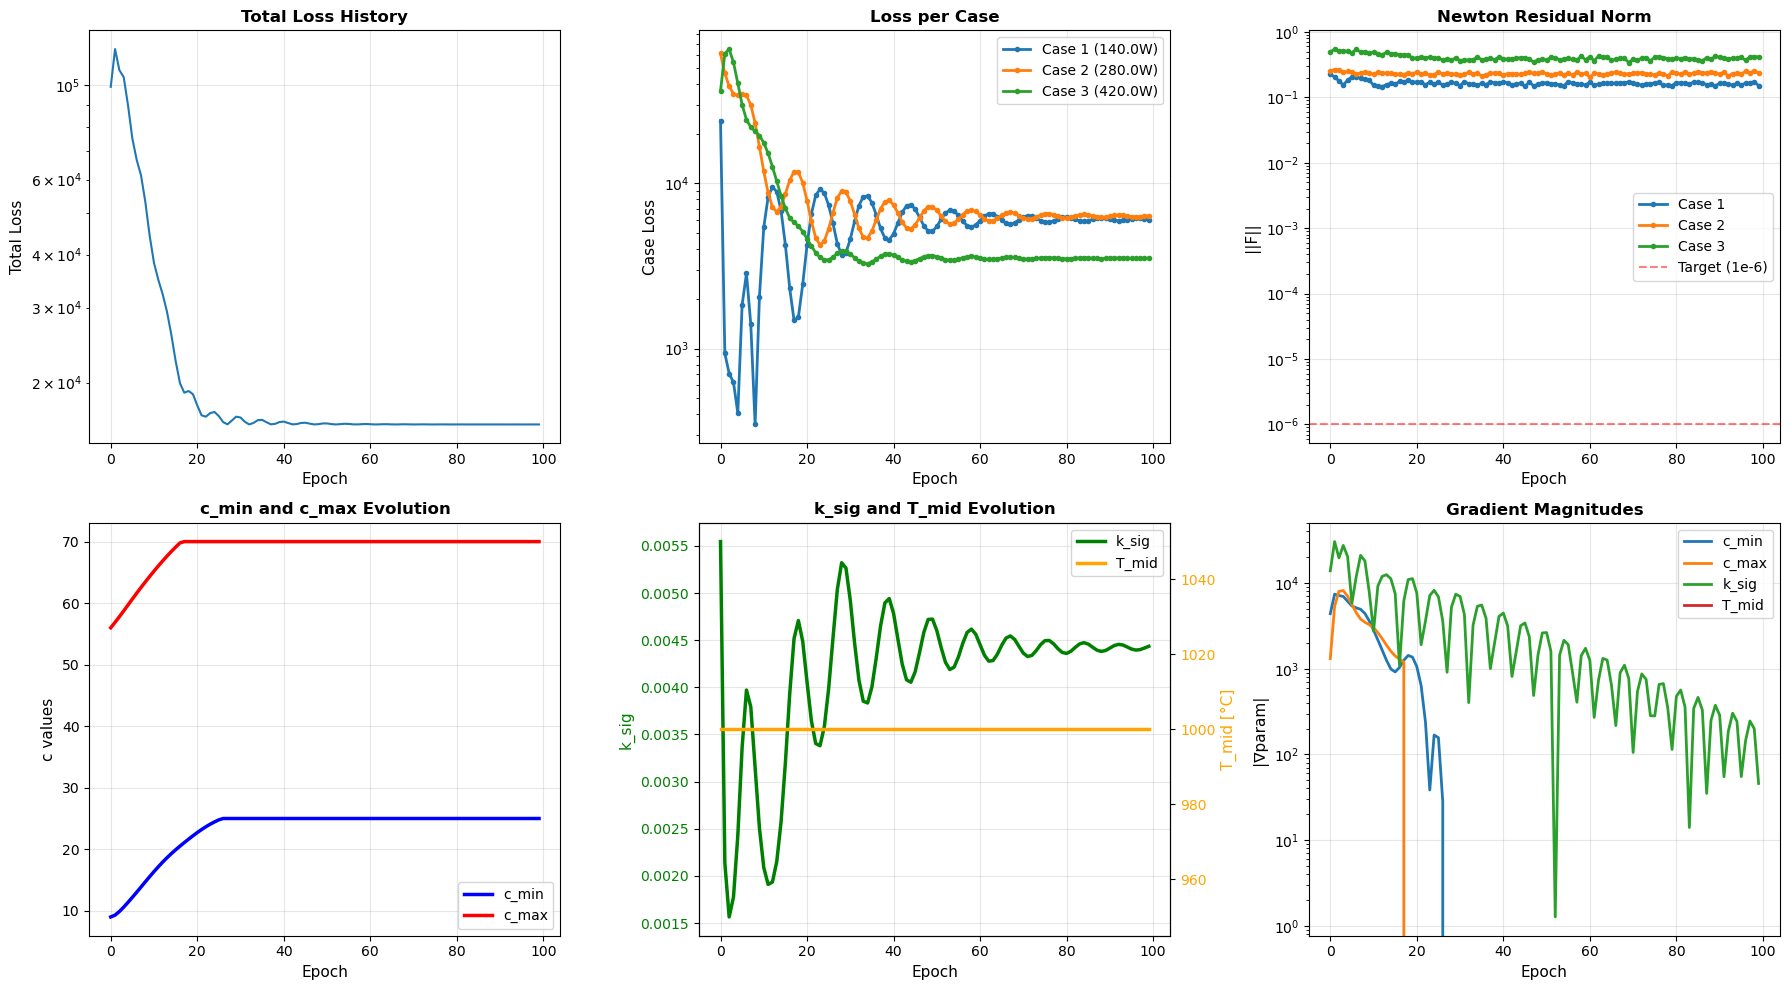

In [15]:
# 11) Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Loss histories and convergence
# Total loss
axes[0, 0].semilogy(history['loss'])
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Total Loss', fontsize=11)
axes[0, 0].set_title('Total Loss History', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Case-wise losses
loss_per_case = np.array(history['loss_per_case'])
for k in range(3):
    axes[0, 1].semilogy(loss_per_case[:, k], label=f'Case {k+1} ({powers[k]}W)',
                        marker='o', markersize=3, linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Case Loss', fontsize=11)
axes[0, 1].set_title('Loss per Case', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Newton convergence
newton_res = np.array(history['newton_res'])
for k in range(3):
    axes[0, 2].semilogy(newton_res[:, k], label=f'Case {k+1}',
                        marker='o', markersize=3, linewidth=2)
axes[0, 2].axhline(1e-6, color='r', linestyle='--', alpha=0.5, label='Target (1e-6)')
axes[0, 2].set_xlabel('Epoch', fontsize=11)
axes[0, 2].set_ylabel('||F||', fontsize=11)
axes[0, 2].set_title('Newton Residual Norm', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Parameters
# c_min and c_max evolution
axes[1, 0].plot(history['c_min'], linewidth=2.5, color='blue', label='c_min')
axes[1, 0].plot(history['c_max'], linewidth=2.5, color='red', label='c_max')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('c values', fontsize=11)
axes[1, 0].set_title('c_min and c_max Evolution', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# k_sig and T_mid evolution (dual axis)
ax1 = axes[1, 1]
ax2 = ax1.twinx()
line1, = ax1.plot(history['k_sig'], linewidth=2.5, color='green', label='k_sig')
line2, = ax2.plot(history['T_mid'], linewidth=2.5, color='orange', label='T_mid')
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('k_sig', fontsize=11, color='green')
ax2.set_ylabel('T_mid [°C]', fontsize=11, color='orange')
ax1.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='orange')
axes[1, 1].set_title('k_sig and T_mid Evolution', fontsize=12, fontweight='bold')
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Gradient magnitudes
grads_array = np.array(history['grads'])
param_names = ['c_min', 'c_max', 'k_sig', 'T_mid']
for i, name in enumerate(param_names):
    axes[1, 2].semilogy(np.abs(grads_array[:, i]), label=name, linewidth=2)
axes[1, 2].set_xlabel('Epoch', fontsize=11)
axes[1, 2].set_ylabel('|∇param|', fontsize=11)
axes[1, 2].set_title('Gradient Magnitudes', fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



FINAL RESULTS - Sigmoid c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))

Learned Parameters:
  c_min = 25.000000 (저온 하한)
  c_max = 70.000000 (고온 상한)
  k_sig = 0.004435 (전이 기울기)
  T_mid = 1000.000 °C (전이 중심)

Fixed Parameters:
  m  = 250.0
  k  = 78.0
  z1 = 0.1 m
  z2 = 0.33 m

c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid))) 함수:
  c(25°C) = 25.588, dc/dT = 0.002575
  c(300°C) = 26.931, dc/dT = 0.008198
  c(500°C) = 29.418, dc/dT = 0.017672
  c(700°C) = 34.408, dc/dT = 0.033003
  c(900°C) = 42.591, dc/dT = 0.047519
  c(1200°C) = 56.872, dc/dT = 0.041237

목표 c 값 vs 학습된 c(Tw) 비교:

케이스 1 (140.0W):
  목표 c:              25.630
  학습된 c(Tw) 평균:   29.514
  학습된 c(Tw) 중심:   30.596
  Tw range:            359.6 ~ 559.9 °C
  c(Tw) range:         27.484 ~ 30.596
  hout(z=0):           52.485
  hout(z=L/2):         30.596
  hout(z=L):           52.498
  Newton:              ||F||=1.516e-01
  TC MSE:              6.017e+03


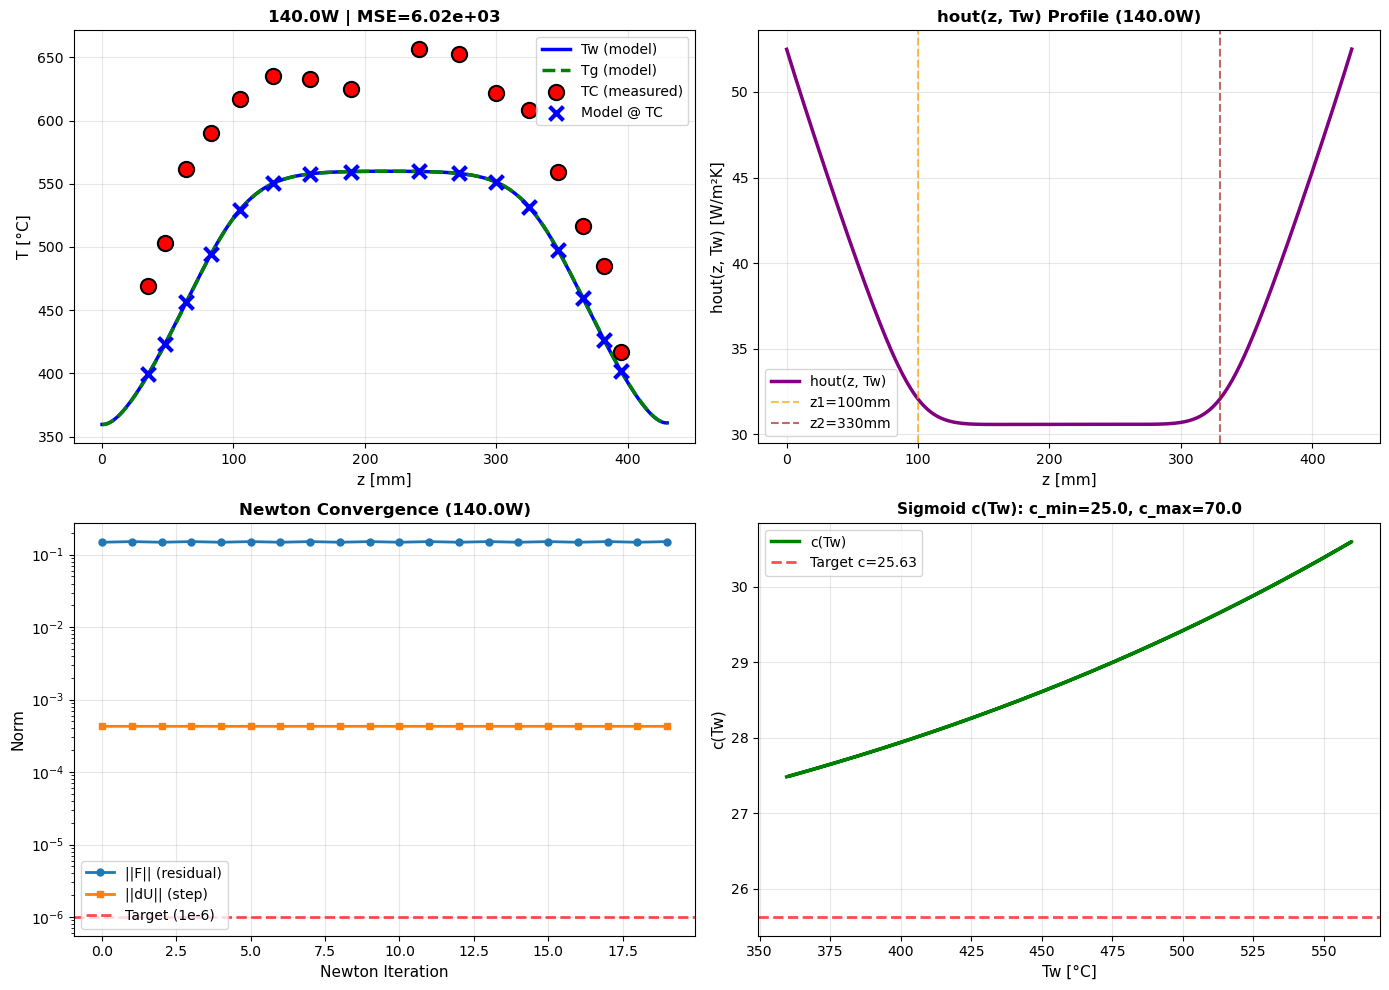


케이스 2 (280.0W):
  목표 c:              43.107
  학습된 c(Tw) 평균:   37.602
  학습된 c(Tw) 중심:   39.995
  Tw range:            631.6 ~ 843.6 °C
  c(Tw) range:         32.347 ~ 39.995
  hout(z=0):           57.349
  hout(z=L/2):         39.996
  hout(z=L):           57.379
  Newton:              ||F||=2.330e-01
  TC MSE:              6.390e+03


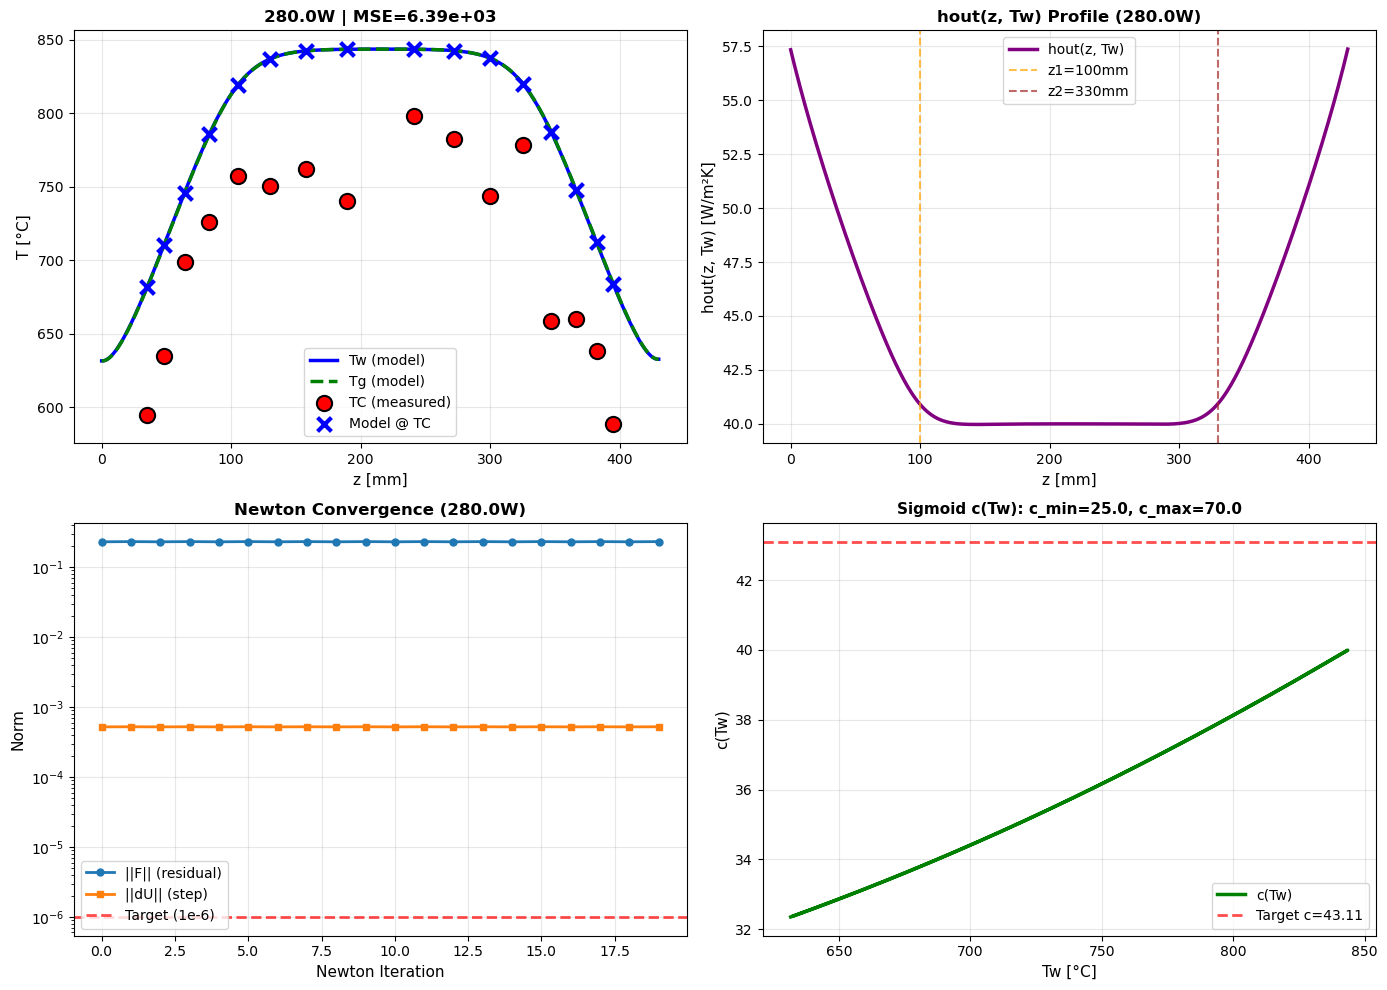


케이스 3 (420.0W):
  목표 c:              49.556
  학습된 c(Tw) 평균:   46.099
  학습된 c(Tw) 중심:   48.931
  Tw range:            827.2 ~ 1028.7 °C
  c(Tw) range:         39.277 ~ 48.931
  hout(z=0):           64.279
  hout(z=L/2):         48.932
  hout(z=L):           64.313
  Newton:              ||F||=3.836e-01
  TC MSE:              3.533e+03


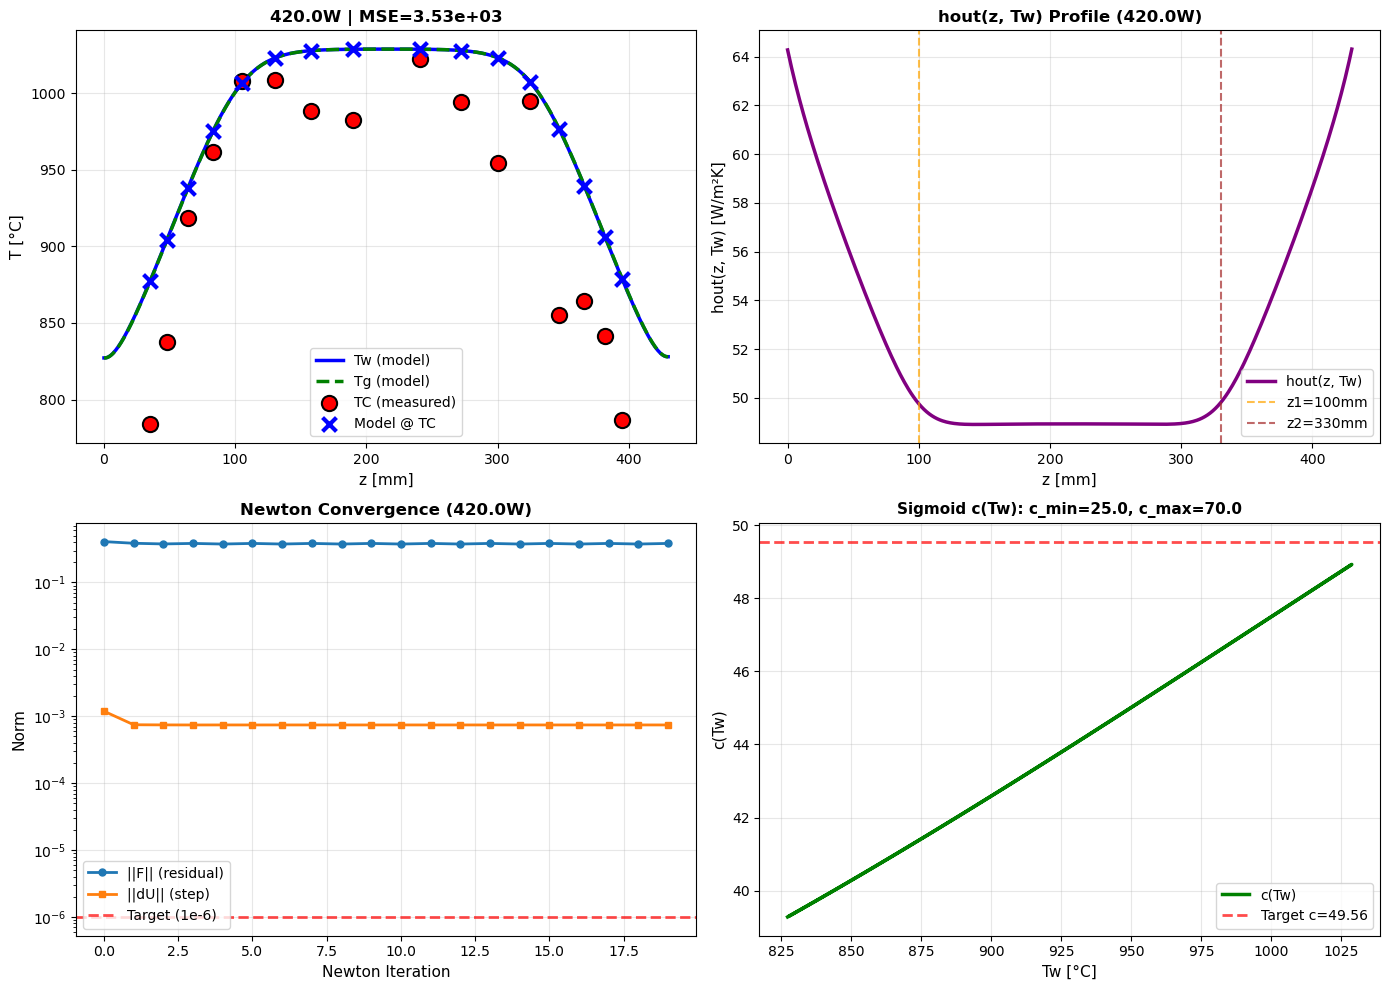

In [16]:
# 12) Final results with hout(z, Tw) profile visualization
c_params_final = c_params_phys(c_params_raw)

print("\n" + "="*80)
print("FINAL RESULTS - Sigmoid c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))")
print("="*80)
print(f"\nLearned Parameters:")
print(f"  c_min = {float(c_params_final[0]):.6f} (저온 하한)")
print(f"  c_max = {float(c_params_final[1]):.6f} (고온 상한)")
print(f"  k_sig = {float(c_params_final[2]):.6f} (전이 기울기)")
print(f"  T_mid = {float(c_params_final[3]):.3f} °C (전이 중심)")
print(f"\nFixed Parameters:")
print(f"  m  = {M_FIXED}")
print(f"  k  = {K_FIXED}")
print(f"  z1 = {Z1_FIXED} m")
print(f"  z2 = {Z2_FIXED} m")
print("\nc(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid))) 함수:")
for T_sample in [25, 300, 500, 700, 900, 1200]:
    sigmoid_val = 1 / (1 + np.exp(-float(c_params_final[2]) * (T_sample - float(c_params_final[3]))))
    c_val = float(c_params_final[0]) + (float(c_params_final[1]) - float(c_params_final[0])) * sigmoid_val
    # dc/dT = (c_max - c_min) * k_sig * sigmoid * (1 - sigmoid)
    dc_dT = (float(c_params_final[1]) - float(c_params_final[0])) * float(c_params_final[2]) * sigmoid_val * (1 - sigmoid_val)
    print(f"  c({T_sample}°C) = {c_val:.3f}, dc/dT = {dc_dT:.6f}")
print("="*80)

# 목표 값과 비교
print("\n목표 c 값 vs 학습된 c(Tw) 비교:")
target_c = [25.63, 43.107, 49.556]
target_names = ['140W', '280W', '420W']

for k, Pw_k in enumerate([140., 280., 420.]):
    res_fn = lambda U: residual(U, c_params_final, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    # c(Tw) 프로파일 계산
    c_Tw_profile = compute_c_of_Tw(c_params_final, Tw)
    c_mean = float(jnp.mean(c_Tw_profile))
    c_at_center = float(c_Tw_profile[n_nodes//2])
    
    # hout(z, Tw) 프로파일 계산
    hout_profile = compute_hout_profile(c_params_final, Tw)
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  목표 c:              {target_c[k]:.3f}")
    print(f"  학습된 c(Tw) 평균:   {c_mean:.3f}")
    print(f"  학습된 c(Tw) 중심:   {c_at_center:.3f}")
    print(f"  Tw range:            {float(Tw.min()):.1f} ~ {float(Tw.max()):.1f} °C")
    print(f"  c(Tw) range:         {float(c_Tw_profile.min()):.3f} ~ {float(c_Tw_profile.max()):.3f}")
    print(f"  hout(z=0):           {float(hout_profile[0]):.3f}")
    print(f"  hout(z=L/2):         {float(hout_profile[n_nodes//2]):.3f}")
    print(f"  hout(z=L):           {float(hout_profile[-1]):.3f}")
    print(f"  Newton:              ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:              {mse:.3e}")
    
    # Temperature and hout profile
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Temperature profile
    axes[0, 0].plot(np.array(z)*1000, np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    axes[0, 0].plot(np.array(z)*1000, np.array(Tg), label='Tg (model)', linewidth=2.5,
                    linestyle='--', color='green')
    axes[0, 0].scatter(np.array(tc_pos)*1000, np.array(T_meas_cases[k]), s=120, c='red',
                       label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    axes[0, 0].scatter(np.array(tc_pos)*1000, np.array(Tw_tc), s=100, c='blue', marker='x',
                       linewidths=3, label='Model @ TC', zorder=5)
    axes[0, 0].set_title(f'{Pw_k}W | MSE={mse:.2e}', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].set_xlabel('z [mm]', fontsize=11)
    axes[0, 0].set_ylabel('T [°C]', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # hout(z, Tw) profile
    axes[0, 1].plot(np.array(z)*1000, np.array(hout_profile), linewidth=2.5, color='purple', label='hout(z, Tw)')
    axes[0, 1].axvline(Z1_FIXED*1000, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z1={Z1_FIXED*1000:.0f}mm')
    axes[0, 1].axvline(Z2_FIXED*1000, color='brown', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z2={Z2_FIXED*1000:.0f}mm')
    axes[0, 1].set_title(f'hout(z, Tw) Profile ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].set_xlabel('z [mm]', fontsize=11)
    axes[0, 1].set_ylabel('hout(z, Tw) [W/m²K]', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Newton convergence
    axes[1, 0].semilogy(np.array(res_hist), label='||F|| (residual)', marker='o',
                        markersize=5, linewidth=2)
    axes[1, 0].semilogy(np.array(step_hist), label='||dU|| (step)', marker='s',
                        markersize=5, linewidth=2)
    axes[1, 0].axhline(1e-6, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Target (1e-6)')
    axes[1, 0].set_title(f'Newton Convergence ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].set_xlabel('Newton Iteration', fontsize=11)
    axes[1, 0].set_ylabel('Norm', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # c(Tw) vs Tw
    axes[1, 1].plot(np.array(Tw), np.array(c_Tw_profile), linewidth=2.5, color='green', label='c(Tw)')
    axes[1, 1].axhline(target_c[k], color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Target c={target_c[k]:.2f}')
    axes[1, 1].set_xlabel('Tw [°C]', fontsize=11)
    axes[1, 1].set_ylabel('c(Tw)', fontsize=11)
    title_str = f'Sigmoid c(Tw): c_min={float(c_params_final[0]):.1f}, c_max={float(c_params_final[1]):.1f}'
    axes[1, 1].set_title(title_str, fontsize=11, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)


c(Tw) Sigmoid Function Analysis


/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1173838386.py:58: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.


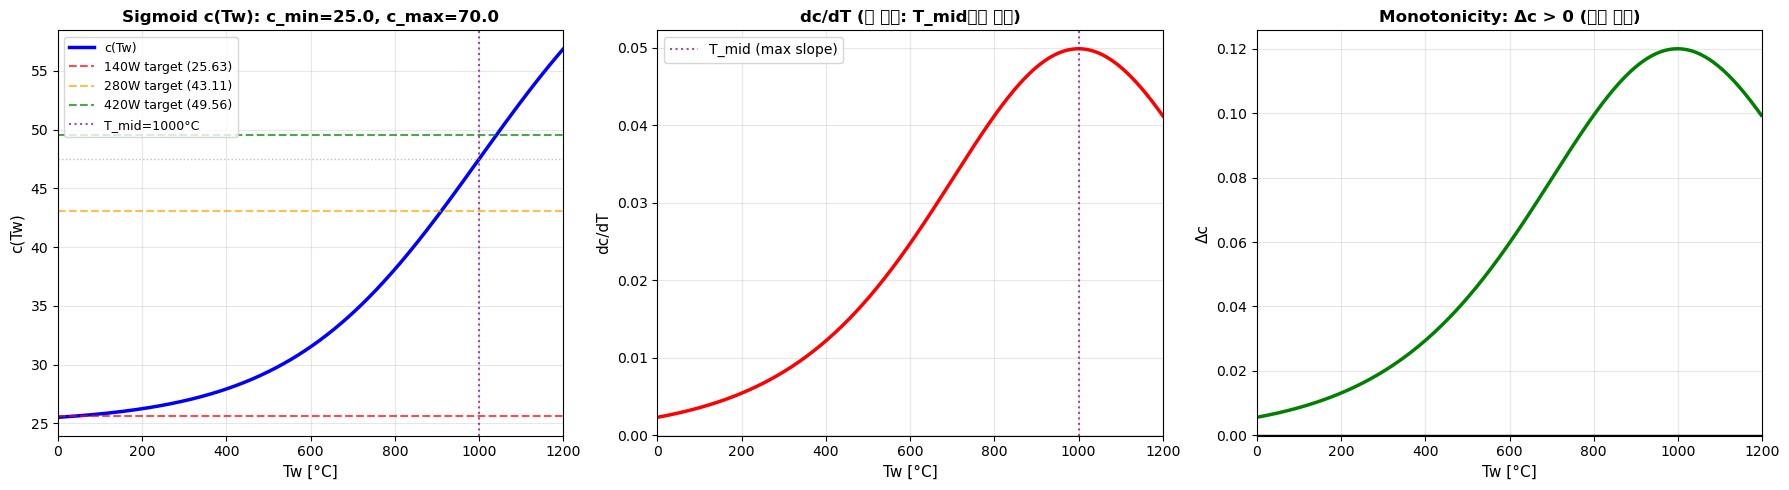


c(Tw) Sigmoid 특성 분석:
  - c(0°C)    = 25.527 (저온 수렴값 ≈ c_min)
  - c(T_mid)  = 47.500 (중간값)
  - c(1200°C) = 56.872 (고온 수렴값 ≈ c_max)
  - Monotonic 증가: True ✅
  - dc/dT at T_mid: 0.049895 (최대 기울기)
  - 저온 수렴: c → 25.0 ✅
  - 고온 수렴: c → 70.0 ✅


In [17]:
# 13) c(Tw) 함수 전체 범위 시각화
print("="*80)
print("c(Tw) Sigmoid Function Analysis")
print("="*80)

# 온도 범위
T_range = np.linspace(0, 1200, 500)

# c(Tw) 계산 (Sigmoid)
c_min_f = float(c_params_final[0])
c_max_f = float(c_params_final[1])
k_sig_f = float(c_params_final[2])
T_mid_f = float(c_params_final[3])

sigmoid_range = 1 / (1 + np.exp(-k_sig_f * (T_range - T_mid_f)))
c_range = c_min_f + (c_max_f - c_min_f) * sigmoid_range

# dc/dT 계산 (미분): dc/dT = (c_max - c_min) * k_sig * sigmoid * (1 - sigmoid)
dc_dT_range = (c_max_f - c_min_f) * k_sig_f * sigmoid_range * (1 - sigmoid_range)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# c(Tw) vs Tw
axes[0].plot(T_range, c_range, linewidth=2.5, color='blue', label='c(Tw)')
# 목표 c 값 표시
axes[0].axhline(25.63, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='140W target (25.63)')
axes[0].axhline(43.107, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='280W target (43.11)')
axes[0].axhline(49.556, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='420W target (49.56)')
# 전이 중심 표시
axes[0].axvline(T_mid_f, color='purple', linestyle=':', linewidth=1.5, alpha=0.7, label=f'T_mid={T_mid_f:.0f}°C')
axes[0].axhline((c_min_f + c_max_f)/2, color='gray', linestyle=':', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Tw [°C]', fontsize=11)
axes[0].set_ylabel('c(Tw)', fontsize=11)
axes[0].set_title(f'Sigmoid c(Tw): c_min={c_min_f:.1f}, c_max={c_max_f:.1f}', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 1200)

# dc/dT vs Tw (기울기 - 종 모양)
axes[1].plot(T_range, dc_dT_range, linewidth=2.5, color='red')
axes[1].axvline(T_mid_f, color='purple', linestyle=':', linewidth=1.5, alpha=0.7, label=f'T_mid (max slope)')
axes[1].set_xlabel('Tw [°C]', fontsize=11)
axes[1].set_ylabel('dc/dT', fontsize=11)
axes[1].set_title('dc/dT (종 모양: T_mid에서 최대)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 1200)

# Monotonicity check
axes[2].plot(T_range[:-1], np.diff(c_range), linewidth=2.5, color='green')
axes[2].axhline(0, color='black', linestyle='-', linewidth=1)
axes[2].set_xlabel('Tw [°C]', fontsize=11)
axes[2].set_ylabel('Δc', fontsize=11)
axes[2].set_title('Monotonicity: Δc > 0 (항상 증가)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 1200)

plt.tight_layout()
plt.show()

print(f"\nc(Tw) Sigmoid 특성 분석:")
print(f"  - c(0°C)    = {c_range[0]:.3f} (저온 수렴값 ≈ c_min)")
print(f"  - c(T_mid)  = {(c_min_f + c_max_f)/2:.3f} (중간값)")
print(f"  - c(1200°C) = {c_range[-1]:.3f} (고온 수렴값 ≈ c_max)")
print(f"  - Monotonic 증가: {np.all(np.diff(c_range) > 0)} ✅")
print(f"  - dc/dT at T_mid: {(c_max_f - c_min_f) * k_sig_f / 4:.6f} (최대 기울기)")
print(f"  - 저온 수렴: c → {c_min_f:.1f} ✅")
print(f"  - 고온 수렴: c → {c_max_f:.1f} ✅")


In [18]:
# 14) Summary and Analysis
print("\n" + "="*80)
print("Sigmoid c(Tw) 최적화 요약")
print("="*80)

print("\n1. 학습 설정:")
print(f"   - 전략: 단일 파라미터 세트로 모든 케이스 동시 피팅")
print(f"   - c(Tw) 함수: 일반화된 Sigmoid")
print(f"     c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))")
print(f"   - 학습 파라미터: [c_min, c_max, k_sig, T_mid] (총 4개)")
print(f"   - 고정 파라미터: m={M_FIXED}, k={K_FIXED}, z1={Z1_FIXED}, z2={Z2_FIXED}")
print(f"   - Learning rate: {LEARNING_RATE}")

print("\n2. 학습 성능:")
loss_reduction = (1 - history['loss'][-1]/history['loss'][0]) * 100
print(f"   - Initial loss: {history['loss'][0]:.6e}")
print(f"   - Final loss:   {history['loss'][-1]:.6e}")
print(f"   - Reduction:    {loss_reduction:.2f}%")

print("\n3. 최종 파라미터 값:")
print(f"   c(Tw) 함수 (Sigmoid):")
print(f"     c_min = {float(c_params_final[0]):.6f} (저온 하한)")
print(f"     c_max = {float(c_params_final[1]):.6f} (고온 상한)")
print(f"     k_sig = {float(c_params_final[2]):.6f} (전이 기울기)")
print(f"     T_mid = {float(c_params_final[3]):.3f} °C (전이 중심)")
print(f"   고정 파라미터:")
print(f"     m  = {M_FIXED}")
print(f"     k  = {K_FIXED}")
print(f"     z1 = {Z1_FIXED} m")
print(f"     z2 = {Z2_FIXED} m")

print("\n4. c(Tw) 함수 분석 (Sigmoid 특성):")
for T_sample in [25, 300, 500, 700, 900, 1200]:
    sigmoid_val = 1 / (1 + np.exp(-float(c_params_final[2]) * (T_sample - float(c_params_final[3]))))
    c_val = float(c_params_final[0]) + (float(c_params_final[1]) - float(c_params_final[0])) * sigmoid_val
    dc_dT = (float(c_params_final[1]) - float(c_params_final[0])) * float(c_params_final[2]) * sigmoid_val * (1 - sigmoid_val)
    print(f"   c({T_sample}°C) = {c_val:.3f}, dc/dT = {dc_dT:.6f}")
print(f"   → 저온 수렴: c → c_min = {float(c_params_final[0]):.2f} (0 이하로 안 내려감) ✅")
print(f"   → 고온 수렴: c → c_max = {float(c_params_final[1]):.2f} ✅")
print(f"   → T_mid = {float(c_params_final[3]):.1f}°C에서 최대 기울기 ✅")
print(f"   → monotonic 증가 (sigmoid 특성) ✅")

print("\n5. 케이스별 성능:")
for k, Pw_k in enumerate([140., 280., 420.]):
    case_loss_final = history['loss_per_case'][-1][k]
    print(f"   Case {k+1} ({Pw_k}W): Loss = {case_loss_final:.3e}")

print("\n6. Gradient 상태:")
final_grads = history['grads'][-1]
param_names = ['c_min', 'c_max', 'k_sig', 'T_mid']
for i, name in enumerate(param_names):
    grad_val = abs(final_grads[i])
    status = "✅ 정상" if grad_val > 1e-10 else "⚠️  약함" if grad_val > 1e-15 else "❌ 소실"
    print(f"   |∇{name}| = {grad_val:.3e} {status}")

print("\n7. test_jax_5-7과 비교:")
print(f"   기존 (케이스별):")
print(f"     140W: c=25.6, m=250, k=81")
print(f"     280W: c=43.1, m=250, k=72")
print(f"     420W: c=49.6, m=250, k=72")
print(f"   신규 (단일 세트, Sigmoid c(Tw)):")
print(f"     c(Tw) = {float(c_params_final[0]):.1f} + ({float(c_params_final[1]):.1f}-{float(c_params_final[0]):.1f}) * sigmoid({float(c_params_final[2]):.4f}*(Tw-{float(c_params_final[3]):.0f}))")
print(f"     m = {M_FIXED} (고정), k = {K_FIXED} (고정)")

print("\n" + "="*80)



Sigmoid c(Tw) 최적화 요약

1. 학습 설정:
   - 전략: 단일 파라미터 세트로 모든 케이스 동시 피팅
   - c(Tw) 함수: 일반화된 Sigmoid
     c(Tw) = c_min + (c_max - c_min) / (1 + exp(-k_sig * (Tw - T_mid)))
   - 학습 파라미터: [c_min, c_max, k_sig, T_mid] (총 4개)
   - 고정 파라미터: m=250.0, k=78.0, z1=0.1, z2=0.33
   - Learning rate: 1.0

2. 학습 성능:
   - Initial loss: 9.914567e+04
   - Final loss:   1.594038e+04
   - Reduction:    83.92%

3. 최종 파라미터 값:
   c(Tw) 함수 (Sigmoid):
     c_min = 25.000000 (저온 하한)
     c_max = 70.000000 (고온 상한)
     k_sig = 0.004435 (전이 기울기)
     T_mid = 1000.000 °C (전이 중심)
   고정 파라미터:
     m  = 250.0
     k  = 78.0
     z1 = 0.1 m
     z2 = 0.33 m

4. c(Tw) 함수 분석 (Sigmoid 특성):
   c(25°C) = 25.588, dc/dT = 0.002575
   c(300°C) = 26.931, dc/dT = 0.008198
   c(500°C) = 29.418, dc/dT = 0.017672
   c(700°C) = 34.408, dc/dT = 0.033003
   c(900°C) = 42.591, dc/dT = 0.047519
   c(1200°C) = 56.872, dc/dT = 0.041237
   → 저온 수렴: c → c_min = 25.00 (0 이하로 안 내려감) ✅
   → 고온 수렴: c → c_max = 70.00 ✅
   → T_mid = 1000.0°C에서 최대 기울

## Manual Parameter Tuning

아래 셀에서 파라미터를 직접 조정하고 결과를 확인할 수 있습니다.

### 조정 가능한 파라미터:
- **c_min**: 저온 하한값 (Tw → -∞일 때 수렴값, 0 이하로 안 내려감)
- **c_max**: 고온 상한값 (Tw → +∞일 때 수렴값)
- **k_sig**: 전이 기울기 (클수록 steep, 작을수록 완만한 전이)
- **T_mid**: 전이 중심 온도 (기울기가 최대인 지점)

### Sigmoid 함수 특성:
- 저온에서 c_min으로 수렴 (0 이하로 안 내려감)
- 고온에서 c_max로 수렴
- T_mid 부근에서 가장 빠르게 변화
- 항상 monotonic 증가

### 고정 파라미터:
- m = 250
- k = 78
- z1 = 0.1 m
- z2 = 0.33 m


MANUAL PARAMETER TUNING

초기 파라미터 (학습 결과):
  c_min = 25.0000 (저온 하한)
  c_max = 70.0000 (고온 상한)
  k_sig = 0.00444 (전이 기울기)
  T_mid = 1000.0 °C (전이 중심)

수정된 파라미터:
  c_min = 5.0000 (저온 하한)
  c_max = 52.0000 (고온 상한)
  k_sig = 0.00800 (전이 기울기)
  T_mid = 625.0 °C (전이 중심)

고정 파라미터:
  m  = 350.0
  k  = 78.0
  z1 = 0.1 m
  z2 = 0.33 m

c(Tw) Sigmoid 함수 미리보기:
  c(25°C) = 5.384
  c(300°C) = 8.250
  c(500°C) = 17.640
  c(700°C) = 35.346
  c(900°C) = 47.312
  c(1200°C) = 51.532

Manual 파라미터로 시뮬레이션 결과:

케이스 1 (140.0W):
  목표 c:              25.630
  학습된 c(Tw) 평균:   22.830
  학습된 c(Tw) 중심:   27.683
  Tw range:            409.9 ~ 616.3 °C
  c(Tw) range:         12.135 ~ 27.683
  hout(z=0):           47.137
  hout(z=L/2):         27.685
  hout(z=L):           47.198
  Newton:              ||F||=1.832e-01
  TC MSE:              5.919e+02


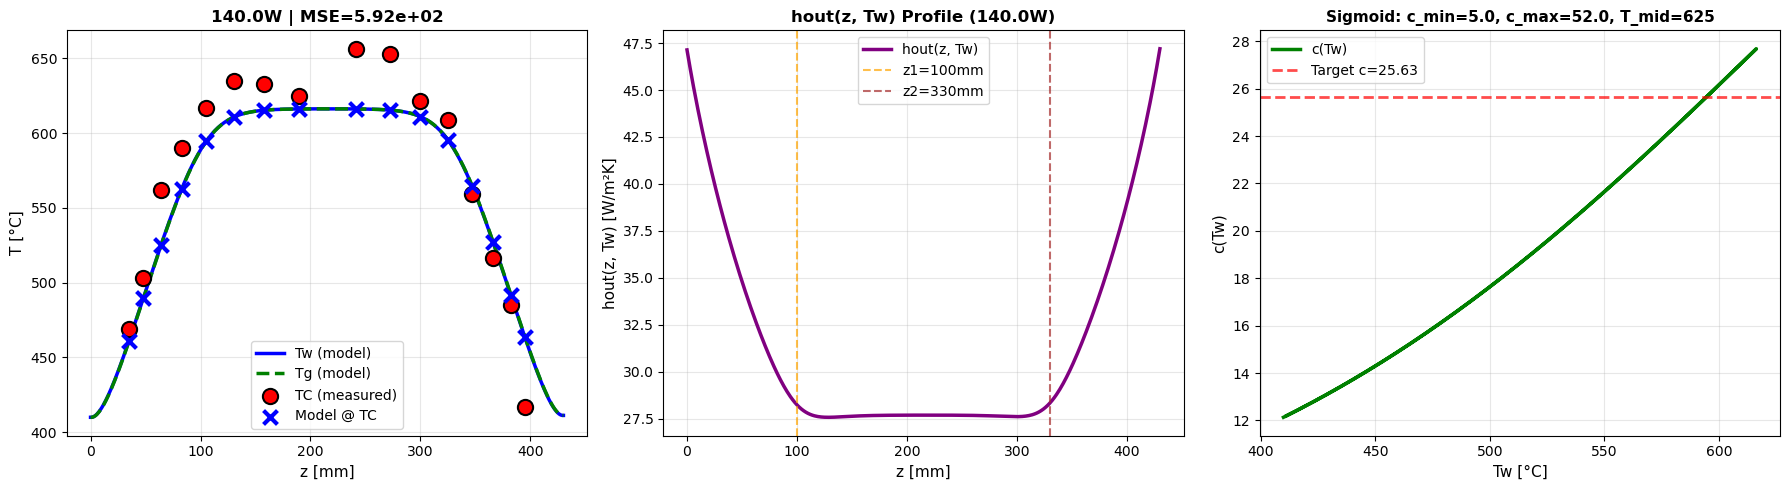


케이스 2 (280.0W):
  목표 c:              43.107
  학습된 c(Tw) 평균:   37.869
  학습된 c(Tw) 중심:   42.464
  Tw range:            597.7 ~ 796.0 °C
  c(Tw) range:         25.942 ~ 42.464
  hout(z=0):           60.943
  hout(z=L/2):         42.465
  hout(z=L):           60.999
  Newton:              ||F||=2.307e-01
  TC MSE:              1.533e+03


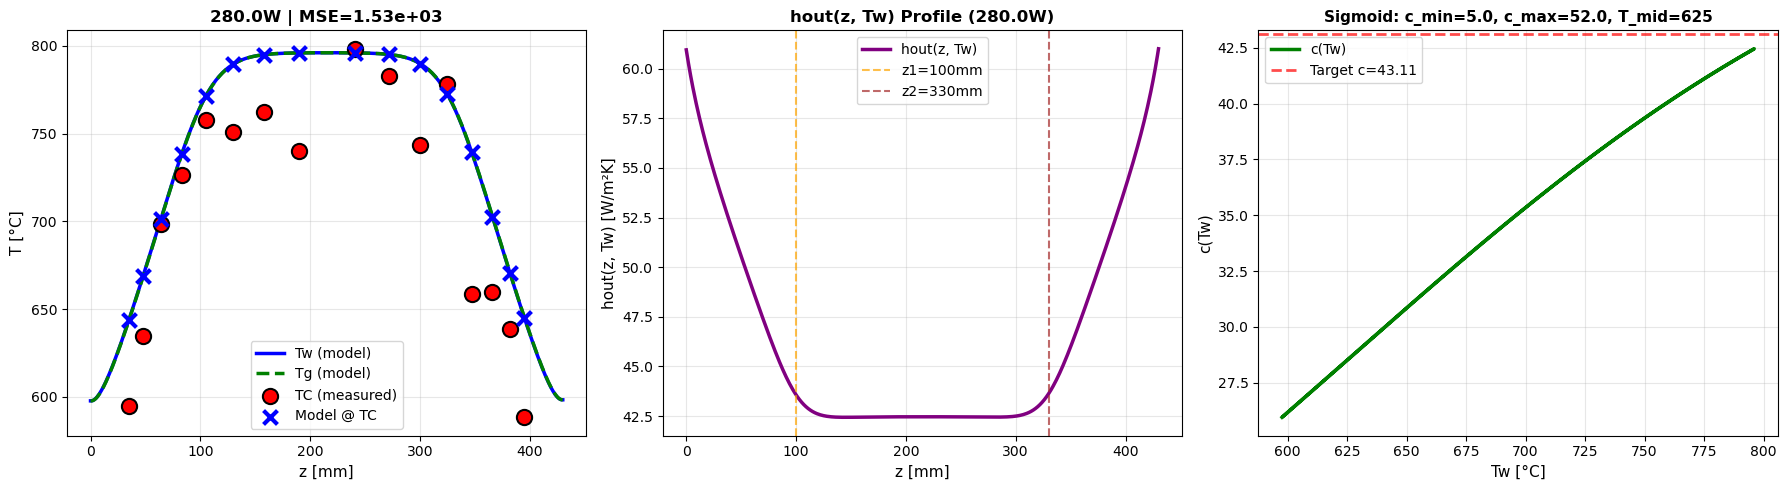


케이스 3 (420.0W):
  목표 c:              49.556
  학습된 c(Tw) 평균:   46.962
  학습된 c(Tw) 중심:   49.915
  Tw range:            733.2 ~ 1008.8 °C
  c(Tw) range:         38.082 ~ 49.915
  hout(z=0):           73.084
  hout(z=L/2):         49.916
  hout(z=L):           73.133
  Newton:              ||F||=2.403e-01
  TC MSE:              9.784e+02


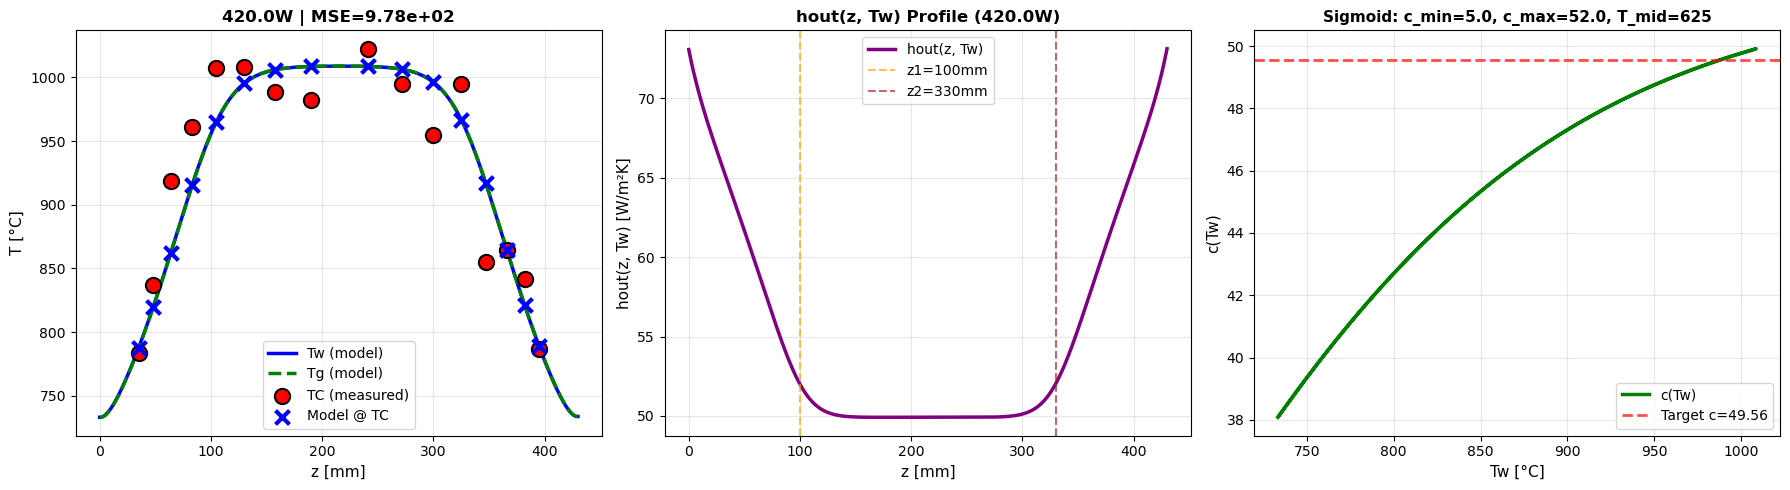


Manual tuning 완료!
파라미터를 수정하고 이 셀을 다시 실행하면 결과를 바로 확인할 수 있습니다.


In [55]:
# 15) Manual Parameter Tuning
# 여기서 파라미터를 직접 수정해서 결과를 확인할 수 있습니다

print("="*80)
print("MANUAL PARAMETER TUNING")
print("="*80)

# 학습된 파라미터를 복사해서 수동 조정
manual_c_params = jnp.array([
    float(c_params_final[0]),  # c_min
    float(c_params_final[1]),  # c_max
    float(c_params_final[2]),  # k_sig
    float(c_params_final[3])   # T_mid
])

print(f"\n초기 파라미터 (학습 결과):")
print(f"  c_min = {manual_c_params[0]:.4f} (저온 하한)")
print(f"  c_max = {manual_c_params[1]:.4f} (고온 상한)")
print(f"  k_sig = {manual_c_params[2]:.5f} (전이 기울기)")
print(f"  T_mid = {manual_c_params[3]:.1f} °C (전이 중심)")

# =========================================================================
# 🔧 여기서 파라미터를 직접 수정하세요!
# =========================================================================
manual_c_params = manual_c_params.at[0].set(5.0)     # c_min: 저온 하한값
manual_c_params = manual_c_params.at[1].set(52.0)     # c_max: 고온 상한값
manual_c_params = manual_c_params.at[2].set(0.008)    # k_sig: 전이 기울기 (작을수록 완만)
manual_c_params = manual_c_params.at[3].set(625.0)    # T_mid: 전이 중심 온도
# =========================================================================

print(f"\n수정된 파라미터:")
print(f"  c_min = {manual_c_params[0]:.4f} (저온 하한)")
print(f"  c_max = {manual_c_params[1]:.4f} (고온 상한)")
print(f"  k_sig = {manual_c_params[2]:.5f} (전이 기울기)")
print(f"  T_mid = {manual_c_params[3]:.1f} °C (전이 중심)")
print(f"\n고정 파라미터:")
print(f"  m  = {M_FIXED}")
print(f"  k  = {K_FIXED}")
print(f"  z1 = {Z1_FIXED} m")
print(f"  z2 = {Z2_FIXED} m")

print("\n" + "="*80)
print("c(Tw) Sigmoid 함수 미리보기:")
print("="*80)
for T_sample in [25, 300, 500, 700, 900, 1200]:
    sigmoid_val = 1 / (1 + np.exp(-float(manual_c_params[2]) * (T_sample - float(manual_c_params[3]))))
    c_val = float(manual_c_params[0]) + (float(manual_c_params[1]) - float(manual_c_params[0])) * sigmoid_val
    print(f"  c({T_sample}°C) = {c_val:.3f}")

# 각 케이스에 대해 시뮬레이션
print("\n" + "="*80)
print("Manual 파라미터로 시뮬레이션 결과:")
print("="*80)

target_c = [25.63, 43.107, 49.556]

for k, Pw_k in enumerate([140., 280., 420.]):
    res_fn = lambda U: residual(U, manual_c_params, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    # c(Tw) 프로파일 계산
    c_Tw_profile = compute_c_of_Tw(manual_c_params, Tw)
    c_mean = float(jnp.mean(c_Tw_profile))
    c_at_center = float(c_Tw_profile[n_nodes//2])
    
    # hout(z, Tw) 프로파일 계산
    hout_profile = compute_hout_profile(manual_c_params, Tw)
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  목표 c:              {target_c[k]:.3f}")
    print(f"  학습된 c(Tw) 평균:   {c_mean:.3f}")
    print(f"  학습된 c(Tw) 중심:   {c_at_center:.3f}")
    print(f"  Tw range:            {float(Tw.min()):.1f} ~ {float(Tw.max()):.1f} °C")
    print(f"  c(Tw) range:         {float(c_Tw_profile.min()):.3f} ~ {float(c_Tw_profile.max()):.3f}")
    print(f"  hout(z=0):           {float(hout_profile[0]):.3f}")
    print(f"  hout(z=L/2):         {float(hout_profile[n_nodes//2]):.3f}")
    print(f"  hout(z=L):           {float(hout_profile[-1]):.3f}")
    print(f"  Newton:              ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:              {mse:.3e}")
    
    # 온도 프로파일 비교 플롯
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Temperature profile
    axes[0].plot(np.array(z)*1000, np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    axes[0].plot(np.array(z)*1000, np.array(Tg), label='Tg (model)', linewidth=2.5,
                    linestyle='--', color='green')
    axes[0].scatter(np.array(tc_pos)*1000, np.array(T_meas_cases[k]), s=120, c='red',
                       label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    axes[0].scatter(np.array(tc_pos)*1000, np.array(Tw_tc), s=100, c='blue', marker='x',
                       linewidths=3, label='Model @ TC', zorder=5)
    axes[0].set_title(f'{Pw_k}W | MSE={mse:.2e}', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].set_xlabel('z [mm]', fontsize=11)
    axes[0].set_ylabel('T [°C]', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # hout(z, Tw) profile
    axes[1].plot(np.array(z)*1000, np.array(hout_profile), linewidth=2.5, color='purple', label='hout(z, Tw)')
    axes[1].axvline(Z1_FIXED*1000, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z1={Z1_FIXED*1000:.0f}mm')
    axes[1].axvline(Z2_FIXED*1000, color='brown', linestyle='--', linewidth=1.5, alpha=0.7, label=f'z2={Z2_FIXED*1000:.0f}mm')
    axes[1].set_title(f'hout(z, Tw) Profile ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].set_xlabel('z [mm]', fontsize=11)
    axes[1].set_ylabel('hout(z, Tw) [W/m²K]', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # c(Tw) vs Tw
    axes[2].plot(np.array(Tw), np.array(c_Tw_profile), linewidth=2.5, color='green', label='c(Tw)')
    axes[2].axhline(target_c[k], color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Target c={target_c[k]:.2f}')
    axes[2].set_xlabel('Tw [°C]', fontsize=11)
    axes[2].set_ylabel('c(Tw)', fontsize=11)
    title_str = f'Sigmoid: c_min={float(manual_c_params[0]):.1f}, c_max={float(manual_c_params[1]):.1f}, T_mid={float(manual_c_params[3]):.0f}'
    axes[2].set_title(title_str, fontsize=11, fontweight='bold')
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("Manual tuning 완료!")
print("파라미터를 수정하고 이 셀을 다시 실행하면 결과를 바로 확인할 수 있습니다.")
print("="*80)


Manual c(Tw) Sigmoid Function Visualization


/tmp/ipykernel_157148/1902640616.py:57: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1902640616.py:57: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1902640616.py:57: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_157148/1902640616.py:57: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sjbaek/miniforge3/envs/jaxenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sjbaek/miniforge3/envs/jaxenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig

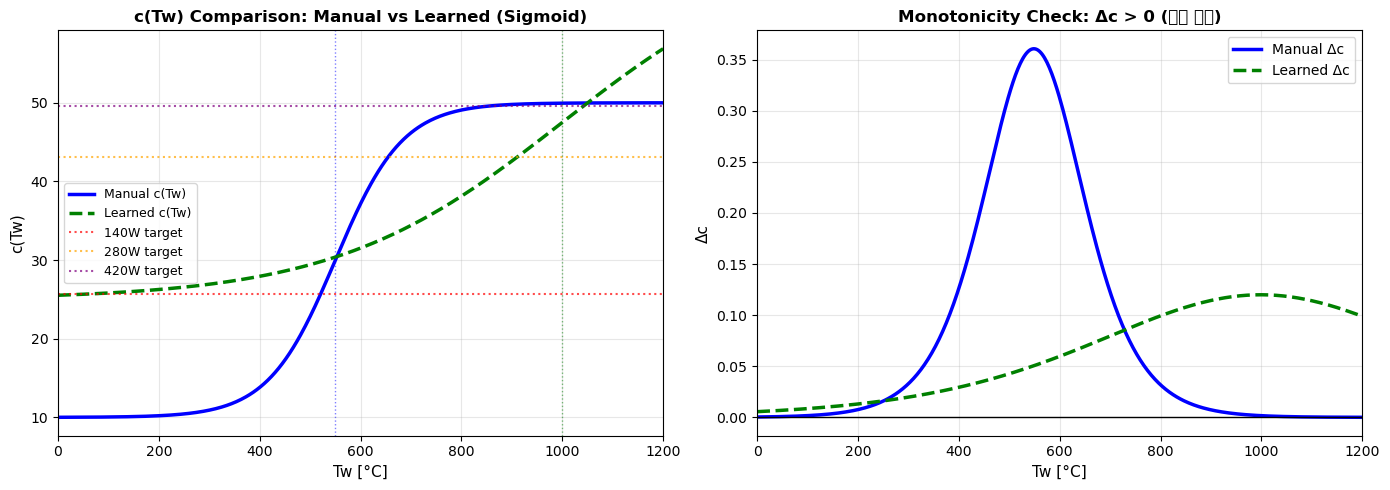


Manual c(Tw) Sigmoid 특성:
  c(0°C)    = 10.010 (저온 수렴값 ≈ c_min)
  c(T_mid)  = 30.000 (중간값)
  c(1200°C) = 49.998 (고온 수렴값 ≈ c_max)
  Monotonic 증가: True ✅


In [30]:
# 16) 전체 온도 범위에서 Manual c(Tw) Sigmoid 함수 시각화
print("="*80)
print("Manual c(Tw) Sigmoid Function Visualization")
print("="*80)

# 온도 범위
T_range = np.linspace(0, 1200, 500)

# Manual c(Tw) 계산 (Sigmoid)
c_min_m = float(manual_c_params[0])
c_max_m = float(manual_c_params[1])
k_sig_m = float(manual_c_params[2])
T_mid_m = float(manual_c_params[3])

sigmoid_manual = 1 / (1 + np.exp(-k_sig_m * (T_range - T_mid_m)))
c_manual = c_min_m + (c_max_m - c_min_m) * sigmoid_manual

# Learned c(Tw) 계산 (비교용)
c_min_l = float(c_params_final[0])
c_max_l = float(c_params_final[1])
k_sig_l = float(c_params_final[2])
T_mid_l = float(c_params_final[3])

sigmoid_learned = 1 / (1 + np.exp(-k_sig_l * (T_range - T_mid_l)))
c_learned = c_min_l + (c_max_l - c_min_l) * sigmoid_learned

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# c(Tw) 비교
axes[0].plot(T_range, c_manual, linewidth=2.5, color='blue', label='Manual c(Tw)')
axes[0].plot(T_range, c_learned, linewidth=2.5, color='green', linestyle='--', label='Learned c(Tw)')
# 목표 c 값 표시
axes[0].axhline(25.63, color='red', linestyle=':', linewidth=1.5, alpha=0.7, label='140W target')
axes[0].axhline(43.107, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='280W target')
axes[0].axhline(49.556, color='purple', linestyle=':', linewidth=1.5, alpha=0.7, label='420W target')
# 전이 중심 표시
axes[0].axvline(T_mid_m, color='blue', linestyle=':', linewidth=1, alpha=0.5)
axes[0].axvline(T_mid_l, color='green', linestyle=':', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Tw [°C]', fontsize=11)
axes[0].set_ylabel('c(Tw)', fontsize=11)
axes[0].set_title('c(Tw) Comparison: Manual vs Learned (Sigmoid)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 1200)

# Monotonicity check
axes[1].plot(T_range[:-1], np.diff(c_manual), linewidth=2.5, color='blue', label='Manual Δc')
axes[1].plot(T_range[:-1], np.diff(c_learned), linewidth=2.5, color='green', linestyle='--', label='Learned Δc')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Tw [°C]', fontsize=11)
axes[1].set_ylabel('Δc', fontsize=11)
axes[1].set_title('Monotonicity Check: Δc > 0 (항상 증가)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 1200)

plt.tight_layout()
plt.show()

print(f"\nManual c(Tw) Sigmoid 특성:")
print(f"  c(0°C)    = {c_manual[0]:.3f} (저온 수렴값 ≈ c_min)")
print(f"  c(T_mid)  = {(c_min_m + c_max_m)/2:.3f} (중간값)")
print(f"  c(1200°C) = {c_manual[-1]:.3f} (고온 수렴값 ≈ c_max)")
print(f"  Monotonic 증가: {np.all(np.diff(c_manual) > 0)} ✅")
